## Project: Deep Learning in for MR Elastography
### B. Model fitting

### 1. import functions and data

In [1]:
import scipy.io
import keras
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import pandas as pd
import random 
from keras.models import Sequential
from keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, UpSampling2D, BatchNormalization, LeakyReLU

from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import MinMaxScaler


%matplotlib inline 



/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Utility functions

In [2]:
def plot_autoencoder_outputs(autoencoder, n, dims):
    decoded_imgs = autoencoder.predict(x_test)

    # number of example digits to show
    n = 5
    plt.figure(figsize=(10, 4.5))
    for i in range(n):
        # plot original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Original Images')

        # plot reconstruction 
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Reconstructed Images')
    plt.show()

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()

#### Import pre-processed data

In [109]:
#df=pd.read_msgpack('/Users/syp/Desktop/git/mre/MREdata_072118.msg')
df=pd.read_msgpack('/Users/syp/OneDrive - Dartmouth College/career/git/mre/MREdata_072118.msg')

In [110]:
Ur=np.stack(df.Ur.values,axis=3).transpose(3,0,1,2)
Ui=np.stack(df.Ui.values,axis=3).transpose(3,0,1,2)

X=np.sqrt(Ui**2+Ur**2)

Y=np.stack(df.RS.values,axis=2).transpose(2,0,1)
#Y=Y.reshape(612,-1)
Y.ptp()

10000

#### Y is transformed 

In [111]:
# Data transformation (scale Y)
Y=Y/10000
print(X.shape)
print(Y.shape)
#print(Y.ptp)
Y.ptp()

(612, 64, 64, 3)
(612, 64, 64)


1.0

#### Split data into train, test and cross-valid samples

In [112]:
train_X,test_X,train_Y,test_Y=train_test_split(X,Y,test_size=0.3)
train_X,valid_X,train_Y,valid_Y=train_test_split(train_X,train_Y,test_size=0.3)

print(X.shape) #612,64,64,3
print(Y.shape) #612,4096
print(train_X.shape) #(299, 64, 64, 3)
print(valid_X.shape) #(129, 64, 64, 3)
print(test_Y.shape) #(184, 4096)



(612, 64, 64, 3)
(612, 64, 64)
(299, 64, 64, 3)
(129, 64, 64, 3)
(184, 64, 64)


### 2. Benchmark model: fully connected neural network

#### Flatten data to use neural network

In [113]:
train_x,train_y=train_X.reshape(len(train_X),-1),train_Y.reshape(len(train_Y),-1)
test_x,test_y=test_X.reshape(len(test_X),-1),test_Y.reshape(len(test_Y),-1)
valid_x,valid_y=valid_X.reshape(len(valid_X),-1),valid_Y.reshape(len(valid_Y),-1)
print(train_x.shape) #(299, 64, 64, 3)
print(valid_x.shape) #(129, 64, 64, 3)
print(test_y.shape) #(184, 4096)

(299, 12288)
(129, 12288)
(184, 4096)


In [100]:
model0=Sequential()
model0.add(Dense(32,activation='relu',input_shape=(train_x.shape[1],)))
#32= # of units

#adding a second layer
model0.add(Dense(100,activation='relu'))

#adding a third layer
model0.add(Dense(100,activation='relu'))

#Final Layer: needs to be the same size as your desired output
model0.add(Dense(train_y.shape[1],activation='linear'))

model0.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                393248    
_________________________________________________________________
dense_6 (Dense)              (None, 100)               3300      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 4096)              413696    
Total params: 820,344
Trainable params: 820,344
Non-trainable params: 0
_________________________________________________________________


In [114]:
model0.compile(loss='mean_squared_error',
             optimizer='adam')

In [117]:
ANN=model0.fit(train_x,train_y,epochs=300,batch_size=299,validation_data=(valid_x,valid_y))

Train on 299 samples, validate on 129 samples
Epoch 1/300
299/299 [==============================] - 0s 235us/step - loss: 0.0025 - val_loss: 0.0044
Epoch 2/300
299/299 [==============================] - 0s 273us/step - loss: 0.0025 - val_loss: 0.0044
Epoch 3/300
299/299 [==============================] - 0s 278us/step - loss: 0.0024 - val_loss: 0.0044
Epoch 4/300
299/299 [==============================] - 0s 268us/step - loss: 0.0024 - val_loss: 0.0044
Epoch 5/300
299/299 [==============================] - 0s 261us/step - loss: 0.0024 - val_loss: 0.0044
Epoch 6/300
299/299 [==============================] - 0s 276us/step - loss: 0.0024 - val_loss: 0.0044
Epoch 7/300
299/299 [==============================] - 0s 263us/step - loss: 0.0024 - val_loss: 0.0044
Epoch 8/300
299/299 [==============================] - 0s 269us/step - loss: 0.0023 - val_loss: 0.0043
Epoch 9/300
299/299 [==============================] - 0s 275us/step - loss: 0.0023 - val_loss: 0.0043
Epoch 10/300
299/299 [=====

<Figure size 576x432 with 0 Axes>

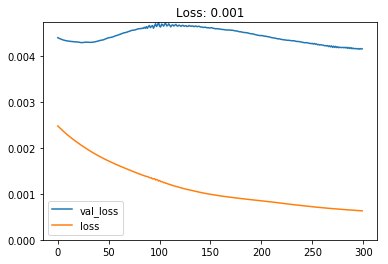

In [118]:
plot_loss(ANN)

In [124]:
predict_y=model0.predict(test_x).reshape(test_x.shape[0],64,64)

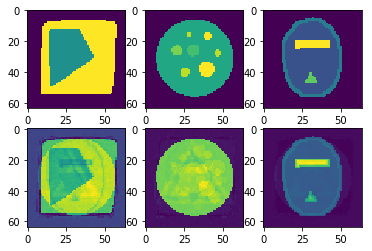

In [133]:
nimg=3
N=50
for i in range(nimg):
    ax=plt.subplot(2,nimg,i+1)
    plt.imshow(test_Y[i+N])
    ax=plt.subplot(2,nimg,i+1+nimg)
    plt.imshow(predict_y[i+N])

### 3. CNN imag reconstruction

In [134]:
#Autoencoder

model1=Sequential()

#Convolution
model1.add(Conv2D(64, kernel_size=(3, 3), strides=(2,2),padding="same",
                 activation='relu',
                 input_shape=(X.shape[1],X.shape[2],X.shape[3])))

model1.add(Conv2D(50, kernel_size=(3, 3), strides=(2,2),padding="same",
                 activation='relu'))

model1.add(Conv2D(32, kernel_size=(3, 3), strides=(2,2),padding="same",
                 activation='relu'))

model1.add(Conv2D(32, kernel_size=(3, 3),padding="same",
                 activation='relu'))

model1.add(Conv2D(32, kernel_size=(3, 3),padding="same",
                 activation='relu'))

#Deconvolution
# model.add(Conv2D(32, kernel_size=(3, 3),padding='same',
#                  activation='relu'))

model1.add(UpSampling2D((2,2)))

model1.add(Conv2D(32, kernel_size=(3, 3),padding='same',
                 activation='relu'))

model1.add(UpSampling2D((2,2)))

model1.add(Conv2D(32, kernel_size=(3, 3),padding='same',
                 activation='relu'))

model1.add(UpSampling2D((2,2)))

model1.add(Conv2D(1, kernel_size=(3, 3),padding='same',
                 activation='relu'))


# model.add(UpSampling2D((2,2)))
# model.add(Flatten())
# model.add(Dense(100, activation='relu'))
# model.add(Dense(Y.shape[1],activation='linear'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 50)        28850     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 8, 8, 32)          14432     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 8, 8, 32)          9248      
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 8, 8, 32)          9248      
_________________________________________________________________
up_sampling2d_7 (UpSampling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 16, 16, 32)        9248      
__________

In [135]:
model1.compile(loss='mean_squared_error',
              optimizer='adam')

train_Y=train_Y.reshape((train_Y.shape[0],64,64,1))
valid_Y=valid_Y.reshape((valid_Y.shape[0],64,64,1))


CNNhistory=model1.fit(train_X, train_Y,
          epochs=300,
          batch_size=299,
          validation_data=(valid_X, valid_Y))

Train on 299 samples, validate on 129 samples
Epoch 1/300
299/299 [==============================] - 4s 14ms/step - loss: 0.0616 - val_loss: 0.0535
Epoch 2/300
299/299 [==============================] - 3s 9ms/step - loss: 0.0578 - val_loss: 0.0475
Epoch 3/300
299/299 [==============================] - 3s 10ms/step - loss: 0.0512 - val_loss: 0.0380
Epoch 4/300
299/299 [==============================] - 3s 9ms/step - loss: 0.0407 - val_loss: 0.0292
Epoch 5/300
299/299 [==============================] - 3s 10ms/step - loss: 0.0303 - val_loss: 0.0483
Epoch 6/300
299/299 [==============================] - 3s 9ms/step - loss: 0.0484 - val_loss: 0.0340
Epoch 7/300
299/299 [==============================] - 3s 10ms/step - loss: 0.0342 - val_loss: 0.0287
Epoch 8/300
299/299 [==============================] - 3s 10ms/step - loss: 0.0296 - val_loss: 0.0301
Epoch 9/300
299/299 [==============================] - 3s 10ms/step - loss: 0.0316 - val_loss: 0.0322
Epoch 10/300
299/299 [=================

<Figure size 576x432 with 0 Axes>

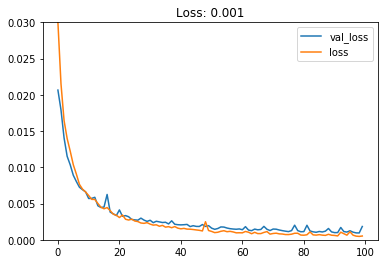

In [58]:
#batchsize=1, epoch=100
plot_loss(CNNhistory)

In [137]:
#CNNhistory=Out[32]
predict_Y=model1.predict(test_X)
print(predict_Y.shape)

(184, 64, 64, 1)


<Figure size 576x432 with 0 Axes>

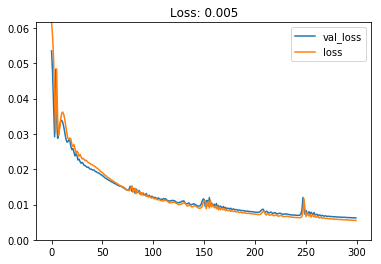

In [138]:
#batchsize=299, epoch=300
plot_loss(CNNhistory)

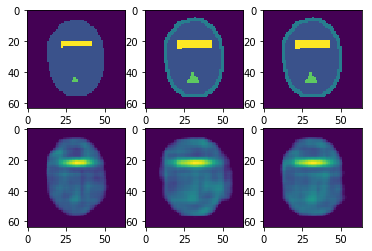

In [139]:
for i in range(nimg):
    ax=plt.subplot(2,nimg,i+1)
    plt.imshow(test_Y[i+35])
    ax=plt.subplot(2,nimg,i+1+nimg)
    plt.imshow(predict_Y[i+35,:,:,0])

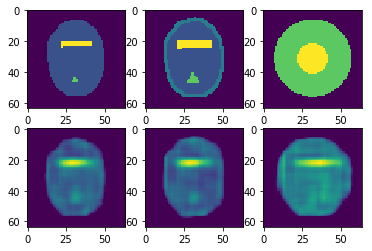

In [140]:
for i in range(nimg):
    ax=plt.subplot(2,nimg,i+1)
    plt.imshow(test_Y[i+10])
    ax=plt.subplot(2,nimg,i+1+nimg)
    plt.imshow(predict_Y[i+10,:,:,0])

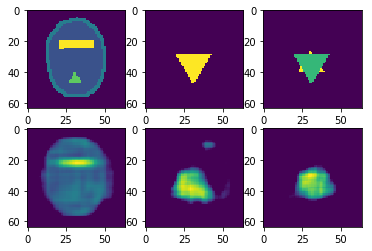

In [141]:
for i in range(nimg):
    ax=plt.subplot(2,nimg,i+1)
    plt.imshow(test_Y[i+20])
    ax=plt.subplot(2,nimg,i+1+nimg)
    plt.imshow(predict_Y[i+20,:,:,0])

<Figure size 576x432 with 0 Axes>

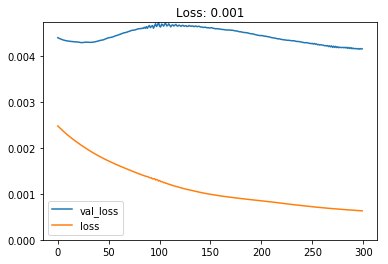

<Figure size 576x432 with 0 Axes>

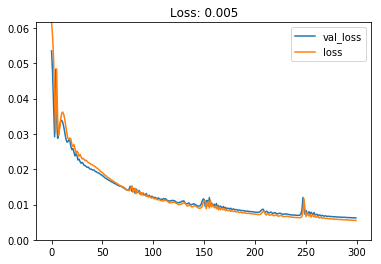

In [142]:
plot_loss(ANN)
plt.hold
plot_loss(CNNhistory)

### NEXT:

1. Increase number of neurons
2. Train longer (epochs)
3. batch size normalization
4. ResNet

### 2.1 Adding batch normalization

In [7]:
#Autoencoder

model2=Sequential()

#Convolution
model2.add(Conv2D(64, kernel_size=(3, 3), strides=(2,2),padding="same",
                 activation='relu',
                 input_shape=(X.shape[1],X.shape[2],X.shape[3])))
model2.add(BatchNormalization())

model2.add(Conv2D(50, kernel_size=(3, 3), strides=(2,2),padding="same",
                 activation='relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(32, kernel_size=(3, 3), strides=(2,2),padding="same",
                 activation='relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(32, kernel_size=(3, 3),padding="same",
                 activation='relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(32, kernel_size=(3, 3),padding="same",
                 activation='relu'))
model2.add(BatchNormalization())

#Deconvolution
# model.add(Conv2D(32, kernel_size=(3, 3),padding='same',
#                  activation='relu'))

model2.add(UpSampling2D((2,2)))

model2.add(Conv2D(32, kernel_size=(3, 3),padding='same',
                 activation='relu'))
model2.add(BatchNormalization())

model2.add(UpSampling2D((2,2)))

model2.add(Conv2D(32, kernel_size=(3, 3),padding='same',
                 activation='relu'))
model2.add(BatchNormalization())

model2.add(UpSampling2D((2,2)))

model2.add(Conv2D(1, kernel_size=(3, 3),padding='same',
                 activation='relu'))
model2.add(BatchNormalization())

# model.add(UpSampling2D((2,2)))
# model.add(Flatten())
# model.add(Dense(100, activation='relu'))
# model.add(Dense(Y.shape[1],activation='linear'))

model2.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 50)        28850     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 50)        200       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          14432     
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 8, 32)          128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 32)          9248      
__________

In [17]:
model2.compile(loss='mean_squared_error',
              optimizer='adam')

train_Y=train_Y.reshape((train_Y.shape[0],64,64,1))
valid_Y=valid_Y.reshape((valid_Y.shape[0],64,64,1))


BatCHCNN=model2.fit(train_X, train_Y,
          epochs=300,
          batch_size=100,
          validation_data=(valid_X, valid_Y))

Train on 299 samples, validate on 129 samples
Epoch 1/300
299/299 [==============================] - 4s 15ms/step - loss: 0.0036 - val_loss: 0.0067
Epoch 2/300
299/299 [==============================] - 4s 12ms/step - loss: 0.0033 - val_loss: 0.0180
Epoch 3/300
299/299 [==============================] - 4s 12ms/step - loss: 0.0023 - val_loss: 0.0077
Epoch 4/300
299/299 [==============================] - 4s 12ms/step - loss: 0.0023 - val_loss: 0.0050
Epoch 5/300
299/299 [==============================] - 4s 12ms/step - loss: 0.0020 - val_loss: 0.0075
Epoch 6/300
299/299 [==============================] - 4s 12ms/step - loss: 0.0018 - val_loss: 0.0058
Epoch 7/300
299/299 [==============================] - 4s 12ms/step - loss: 0.0017 - val_loss: 0

In [18]:
#BatCHhistory=Out[11]
predict_Y=model2.predict(test_X)
print(predict_Y.shape)

(184, 64, 64, 1)


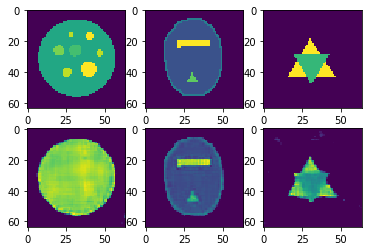

In [19]:
nimg=3
for i in range(nimg):
    ax=plt.subplot(2,nimg,i+1)
    plt.imshow(test_Y[i+35])
    ax=plt.subplot(2,nimg,i+1+nimg)
    plt.imshow(predict_Y[i+35,:,:,0])

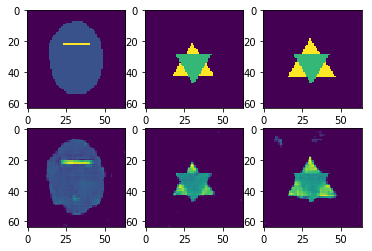

In [20]:
nimg=3
for i in range(nimg):
    ax=plt.subplot(2,nimg,i+1)
    plt.imshow(test_Y[i+10])
    ax=plt.subplot(2,nimg,i+1+nimg)
    plt.imshow(predict_Y[i+10,:,:,0])

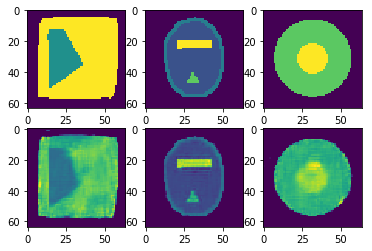

In [21]:
for i in range(nimg):
    ax=plt.subplot(2,nimg,i+1)
    plt.imshow(test_Y[i+20])
    ax=plt.subplot(2,nimg,i+1+nimg)
    plt.imshow(predict_Y[i+20,:,:,0])

### Result seems better with batchnormalization

Text(0.5,1,'validation loss over time')

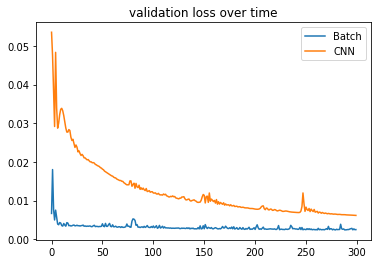

In [145]:
plt.hold
ax=plt.plot(BatCHCNN.epoch,BatCHCNN.history['val_loss'])
ax=plt.plot(CNNhistory.epoch,CNNhistory.history['val_loss'])
plt.legend(['Batch','CNN'])
plt.title('validation loss over time')

#### 2.2 Use a ResNet
##### Will resnet work?
The assumption of resnet is that the optimal function a block is trying to model is closer to an identity mapping than to a zero mapping, and that it should be easier to find the perturbations with reference to an identity mapping than to a zero mapping.

In [23]:
from keras import layers


def residual_block(y, nb_channels, _strides=(1, 1), _project_shortcut=False):
    shortcut = y

    # down-sampling is performed with a stride of 2
    y = layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
    y = layers.BatchNormalization()(y)
    y = layers.LeakyReLU()(y)

    y = layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=(1, 1), padding='same')(y)
    y = layers.BatchNormalization()(y)

    # identity shortcuts used directly when the input and output are of the same dimensions
    if _project_shortcut or _strides != (1, 1):
        # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
        # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
        shortcut = layers.Conv2D(nb_channels, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    y = layers.add([shortcut, y])
    y = layers.LeakyReLU()(y)

    return y

In [24]:
## recreate the CNN with residual layers
#Autoencoder

def residual_network(x):
    x=residual_block(x,64,(2,2))
    x=residual_block(x,50, (2,2))
    x=residual_block(x,32,(2,2))
    x=UpSampling2D((2,2))(x)
    x=residual_block(x,32)
    x=UpSampling2D((2,2))(x)
    x=residual_block(x,32)
    x=UpSampling2D((2,2))(x)
    x=residual_block(x,1,(1,1),True)
    return x
image_tensor = layers.Input(shape=(X.shape[1],X.shape[2],X.shape[3]))
network_output = residual_network(image_tensor)


In [25]:
from keras.models import Model
model3 = Model(inputs=image_tensor, outputs=network_output)
model3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 32, 32, 64)   256         conv2d_9[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 32, 32, 64)   0           batch_normalization_9[0][0]      
__________________________________________________________________________________________________
conv2d_11 

In [26]:
model3.compile(loss='mean_squared_error',
              optimizer='adam')

train_Y=train_Y.reshape((train_Y.shape[0],64,64,1))
valid_Y=valid_Y.reshape((valid_Y.shape[0],64,64,1))

In [27]:
train_X.shape

(299, 64, 64, 3)

In [48]:
ResCNN=model3.fit(train_X, train_Y,epochs=300,batch_size=299,validation_data=(valid_X, valid_Y))

Train on 299 samples, validate on 129 samples
Epoch 1/300
299/299 [==============================] - 8s 25ms/step - loss: 0.0015 - val_loss: 0.0331
Epoch 2/300
299/299 [==============================] - 7s 24ms/step - loss: 0.0015 - val_loss: 0.0322
Epoch 3/300
299/299 [==============================] - 7s 25ms/step - loss: 0.0015 - val_loss: 0.0313
Epoch 4/300
299/299 [==============================] - 8s 26ms/step - loss: 0.0015 - val_loss: 0.0304
Epoch 5/300
299/299 [==============================] - 7s 24ms/step - loss: 0.0015 - val_loss: 0.0299
Epoch 6/300
299/299 [==============================] - 7s 25ms/step - loss: 0.0015 - val_loss: 0.0295
Epoch 7/300
299/299 [==============================] - 7s 25ms/step - loss: 0.0015 - val_loss: 0.0292
Epoch 8/300
299/299 [==============================] - 8s 26ms/step - loss: 0.0015 - val_loss: 0.0289
Epoch 9/300
299/299 [==============================] - 8s 27ms/step - loss: 0.0015 - val_loss: 0.0289
Epoch 10/300
299/299 [==============

<Figure size 576x432 with 0 Axes>

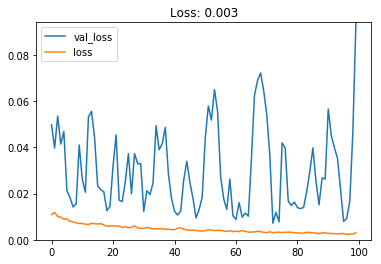

In [37]:
plot_loss(ResCNN) #batchsize=10, epoch=100

### Why does the validation loss jump so much?
Batchsize was too small.

<Figure size 576x432 with 0 Axes>

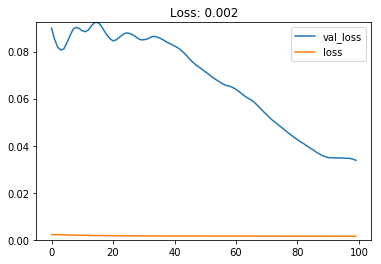

In [41]:
plot_loss(ResCNN) #batchsize=299, epoch=100

<Figure size 576x432 with 0 Axes>

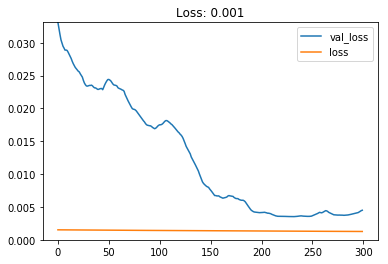

In [49]:
plot_loss(ResCNN) #batchsize=299, epoch=300

In [50]:
predict_Y=model3.predict(test_X)
print(predict_Y.shape)

(184, 64, 64, 1)


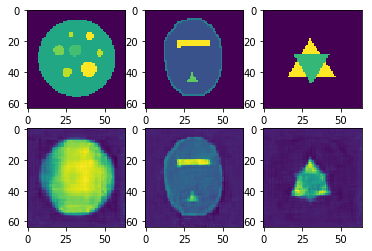

In [57]:
nimg=3
N=35
for i in range(nimg):
    ax=plt.subplot(2,nimg,i+1)
    plt.imshow(test_Y[i+N])
    ax=plt.subplot(2,nimg,i+1+nimg)
    plt.imshow(predict_Y[i+N,:,:,0])

Text(0.5,1,'validation loss over time')

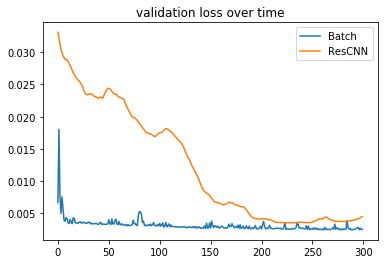

In [152]:
plt.hold
#ax=plt.plot(ANN.epoch,ANN.history['val_loss'])
#ax=plt.plot(CNNhistory.epoch,CNNhistory.history['val_loss'])
ax=plt.plot(BatCHCNN.epoch,BatCHCNN.history['val_loss'])
ax=plt.plot(ResCNN.epoch,ResCNN.history['val_loss'])

plt.legend(['Batch','ResCNN'])
plt.title('validation loss over time')